Project Title (GitHub & LinkedIn)
"Macro-Aware Robo-Advisor: Predicting Risk, Optimizing Portfolios, and Personalizing Finance"

or something like:

"FinIntelli: A Full-Stack Financial Intelligence System for Risk Detection and Investment Planning"

# Module 1: Yield Curve Inversion Predictor

In [ ]:
!pip install fredapi xgboost imbalanced-learn --quiet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
fred = Fred(api_key='bbee39532cda9d3d45bbf35b603547e2')

In [ ]:
# ✅ STEP 3: Define date range for analysis
start_date = '2000-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

In [ ]:
# ✅ STEP 4: Fetch Treasury Yield Data
yield_10y = fred.get_series('GS10', observation_start=start_date)
yield_2y = fred.get_series('GS2', observation_start=start_date)
yield_3m = fred.get_series('GS3M', observation_start=start_date)

In [ ]:
# ✅ STEP 5: Fetch macroeconomic indicators
unemployment = fred.get_series('UNRATE', observation_start=start_date)
inflation = fred.get_series('CPIAUCSL', observation_start=start_date)
recession = fred.get_series('USREC', observation_start=start_date)

In [ ]:
# ✅ STEP 6: Combine into one DataFrame
yield_data = pd.concat([yield_10y, yield_2y, yield_3m, unemployment, inflation, recession], axis=1)
yield_data.columns = ['10Y', '2Y', '3M', 'Unemployment', 'Inflation', 'Recession']
yield_data = yield_data.dropna()

In [ ]:
# ✅ STEP 7: Create yield spreads
yield_data['10Y-2Y'] = yield_data['10Y'] - yield_data['2Y']
yield_data['10Y-3M'] = yield_data['10Y'] - yield_data['3M']

In [ ]:
# ✅ STEP 8: Create lagged features (1-period lag)
yield_data['10Y-2Y_lag1'] = yield_data['10Y-2Y'].shift(1)
yield_data['10Y-3M_lag1'] = yield_data['10Y-3M'].shift(1)
yield_data['Unemployment_lag1'] = yield_data['Unemployment'].shift(1)
yield_data['Inflation_lag1'] = yield_data['Inflation'].shift(1)
yield_data['Recession_lag1'] = yield_data['Recession'].shift(1)

In [ ]:
# ✅ STEP 9: Create inversion label (target = current inversion)
yield_data['Inversion'] = (yield_data['10Y-2Y'] < 0).astype(int)
yield_data = yield_data.dropna()

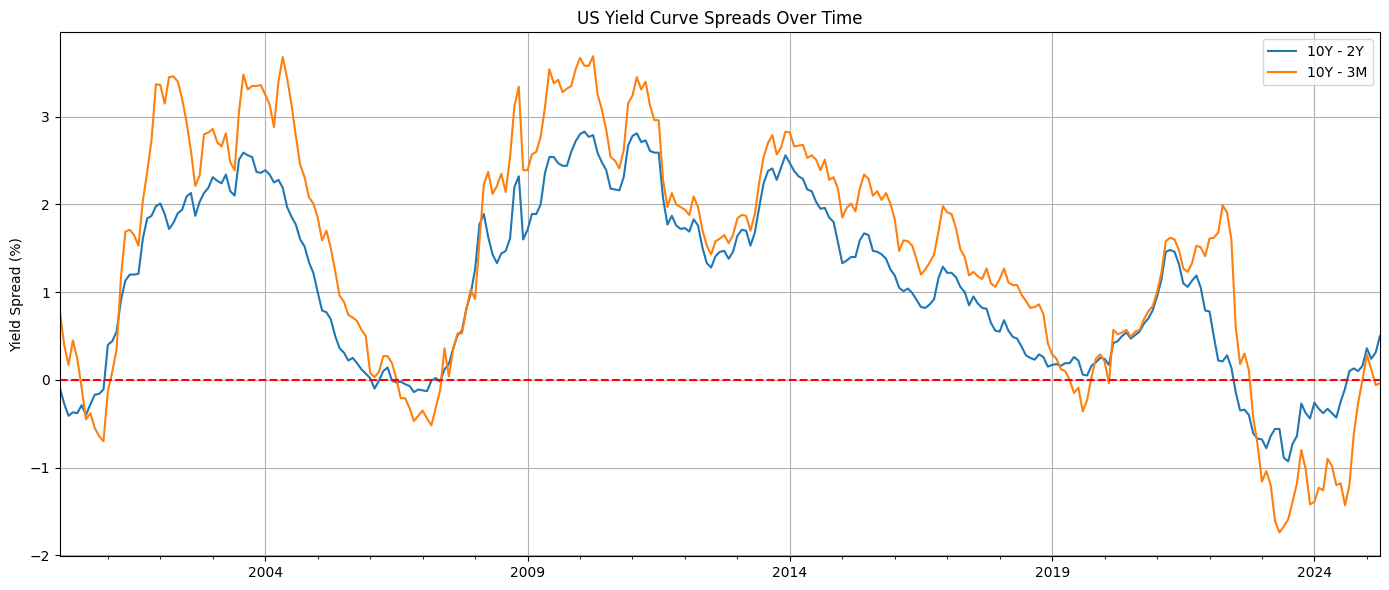

In [ ]:
# ✅ STEP 10: Plot the yield curves & inversions
plt.figure(figsize=(14, 6))
yield_data['10Y-2Y'].plot(label='10Y - 2Y')
yield_data['10Y-3M'].plot(label='10Y - 3M')
plt.axhline(0, color='red', linestyle='--')
plt.title('US Yield Curve Spreads Over Time')
plt.ylabel('Yield Spread (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ✅ STEP 11: Feature selection
features = ['10Y-2Y_lag1', '10Y-3M_lag1', 'Unemployment_lag1', 'Inflation_lag1', 'Recession_lag1']
X = yield_data[features]
y = yield_data['Inversion']

In [ ]:
# ✅ STEP 12: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# ✅ STEP 13: Apply SMOTE to balance the training set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

In [ ]:
# ✅ STEP 14: Train XGBoost on balanced data
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(X_train_bal, y_train_bal)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# ✅ STEP 15: Model Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        35
           1       0.00      0.00      0.00        26

    accuracy                           0.57        61
   macro avg       0.29      0.50      0.36        61
weighted avg       0.33      0.57      0.42        61


Confusion Matrix:
[[35  0]
 [26  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


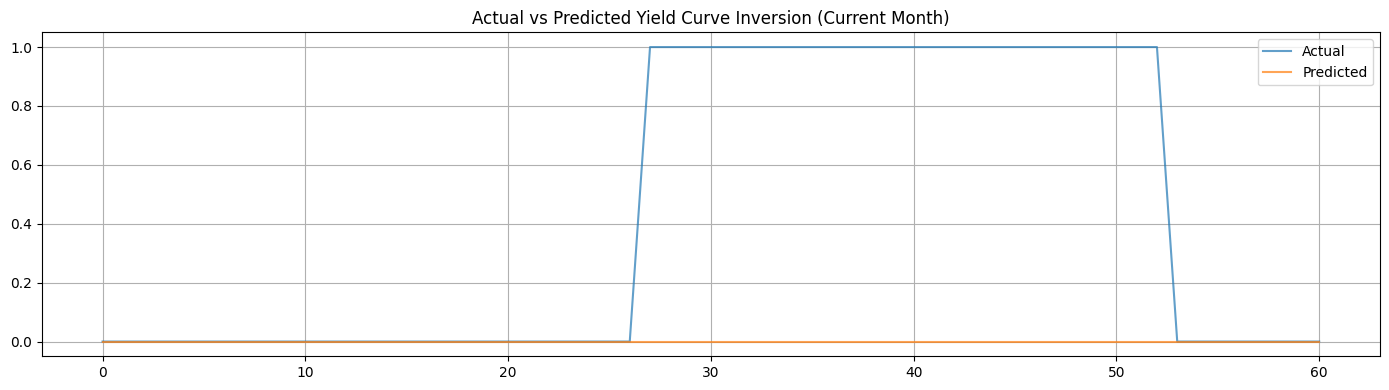

In [ ]:
# ✅ STEP 16: Plot predicted vs actual
plt.figure(figsize=(14, 4))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Yield Curve Inversion (Current Month)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

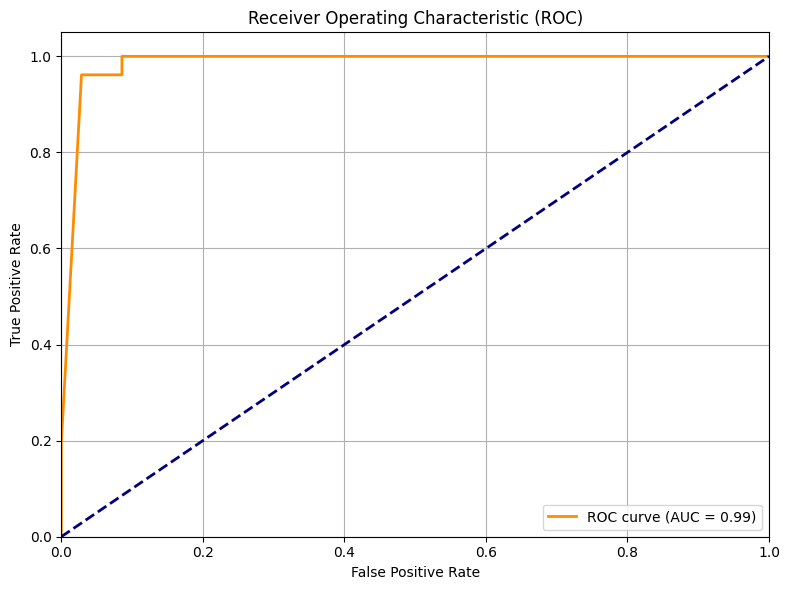

In [ ]:
# ✅ STEP 17: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ✅ STEP 18: Cross-validation for AUC
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print("\nCross-Validated AUC Scores:", cv_scores)
print("Mean AUC:", cv_scores.mean())



Cross-Validated AUC Scores: [0.98039216 0.98137255 1.         1.         0.996     ]
Mean AUC: 0.9915529411764705


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
output_path = '/content/drive/MyDrive/Fintech-Project/data/module1_output.csv'

In [ ]:
output_df = X_test.copy()
output_df['Actual_Inversion'] = y_test.values
output_df['Predicted_Inversion'] = y_pred
output_df['Inversion_Probability'] = y_prob
output_df.to_csv(output_path)

In [ ]:
import joblib
joblib.dump(model, '/content/drive/MyDrive/Fintech-Project/models/xgb_yieldcurve_model.pkl')

['/content/drive/MyDrive/Fintech-Project/models/xgb_yieldcurve_model.pkl']

# Testing new appproach

In [116]:
# ✅ Explore data availability for time-series modeling
print("Start date:", yield_data.index.min().strftime('%Y-%m-%d'))
print("End date:", yield_data.index.max().strftime('%Y-%m-%d'))
print("Total days of data:", len(yield_data))

# Downsample to monthly if needed
monthly_data = yield_data.resample('M').mean()
print("Monthly records available:", len(monthly_data))

# Check missing values
print("\nMissing values per column:")
print(yield_data.isnull().sum())

Start date: 2000-02-01
End date: 2025-04-01
Total days of data: 303
Monthly records available: 303

Missing values per column:
10Y                  0
2Y                   0
3M                   0
Unemployment         0
Inflation            0
Recession            0
10Y-2Y               0
10Y-3M               0
10Y-2Y_lag1          0
10Y-3M_lag1          0
Unemployment_lag1    0
Inflation_lag1       0
Recession_lag1       0
Inversion            0
dtype: int64


<ipython-input-116-4471f4b678a4>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = yield_data.resample('M').mean()
